In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

# Remove NaN values
df = df.dropna()

In [4]:
df.head(2)

,open,close,high,low,volume,"RV_d,t",count,daily_return,"RV_w,t","RV_m,t",...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
time,,,,,,,,,,,,,,,,,,,,,
2016-07-01,12.479,12.194,12.580,11.74,88143.261594,0.000007,604,-0.017405,0.00001,0.000016,...,98.152,97.816,22.65,26.08,20.5,90.0,298196.36,732272.62,3243.8555,13.0704
2016-07-02,12.190,12.136,12.213,11.95,25168.057827,0.000007,362,-0.004756,0.00001,0.000016,...,98.152,97.816,22.65,26.08,20.5,90.0,298196.36,732272.62,3243.8555,13.0704


In [5]:
df.tail(2)

,open,close,high,low,volume,"RV_d,t",count,daily_return,"RV_w,t","RV_m,t",...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
time,,,,,,,,,,,,,,,,,,,,,
2023-10-07,1645.5,1634.5,1647.9,1630.5,953.564307,1.083754e-07,435,-0.006806,9.382365e-07,5.007031e-07,...,119.846,124.332,29.97,34.67,26.65,63.8,513250.88,916401.9,5038.9871,19.0462
2023-10-08,1634.5,1626.5,1641.2,1625.9,646.669448,1.470255e-07,186,-0.004894,4.456596e-07,4.968591e-07,...,119.846,124.332,29.97,34.67,26.65,63.8,513250.88,916401.9,5038.9871,19.0462


In [6]:
log_return = np.log(df['close'] / df['close'].shift(1))
df['log_return'] = log_return
df.dropna(inplace=True)

In [13]:
df[['RV_d,t','daily_return','log_return']].head(5)

,"RV_d,t",daily_return,log_return
time,,,
2016-07-02,0.000007,-0.004756,-0.004768
2016-07-03,0.000010,-0.030735,-0.031217
2016-07-04,0.000008,-0.024824,-0.025137
2016-07-05,0.000022,-0.076977,-0.080101
2016-07-06,0.000012,-0.000944,-0.000945


### Train-Test Split (without validation)

In [8]:
# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(df))
r_train, r_test = df['daily_return'][:train_size], df['daily_return'][train_size:]
lr_train, lr_test = df['log_return'][:train_size], df['log_return'][train_size:]
RV_train, RV_test = df['RV_d,t'][:train_size], df['RV_d,t'][train_size:]
train_size = len(lr_train)
test_size = len(lr_test)

print("Training Set:", r_train.shape, lr_train.shape, RV_train.shape)
print("Test Set:", r_test.shape, lr_test.shape, RV_test.shape)
print(lr_train.index[0])
print(lr_test.index[0])

Training Set: (2090,) (2090,) (2090,)
Test Set: (523,) (523,) (523,)
2016-07-02 00:00:00
2022-04-30 00:00:00


In [18]:
r_train.tail()

time
2022-04-25    0.028763
2022-04-26   -0.065492
2022-04-27    0.028341
2022-04-28    0.016220
2022-04-29   -0.040596
Name: daily_return, dtype: float64

In [22]:
RV_train.tail()

time
2022-04-25    9.316834e-07
2022-04-26    9.322617e-07
2022-04-27    9.856318e-07
2022-04-28    1.074644e-06
2022-04-29    7.218086e-07
Name: RV_d,t, dtype: float64

#### Use Garch(1,1)

$ \sigma^2_t = \omega + \alpha RV^{scaled}_{t-1} + \beta \sigma^2_{t-1} $

In [24]:
p = 1
q = 1

#### Fit on Training Set

In [35]:
model = arch_model(lr_train, vol='Garch', p=p, q=q, rescale=False)
garch_fit = model.fit(disp="off")

In [36]:
params = garch_fit.params
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]

In [37]:
garch_fit.forecast(horizon=1).variance.tail()

,h.1
time,
2022-04-29,0.001386


In [38]:
cond_var = garch_fit.conditional_volatility[0:]

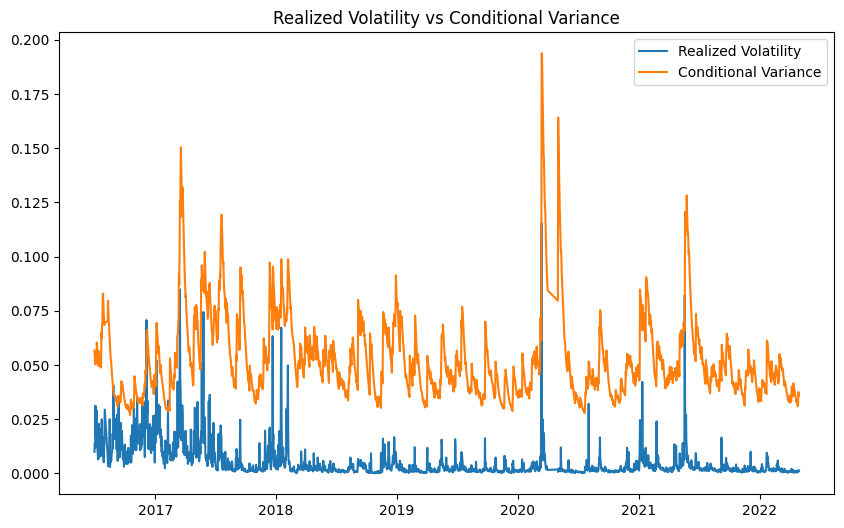

In [39]:
# plot the conditional variance and realised volatility
plt.figure(figsize=(10, 6))
plt.plot(RV_train*1440, label='Realized Volatility')
plt.plot(cond_var, label='Conditional Variance')
plt.legend()
plt.title('Realized Volatility vs Conditional Variance')
plt.show()


#### Forecast Testing Set

In [32]:
predicted_volatility = []

# Get the most recent realised variances
last_RV = RV_train[train_size-q:train_size]
last_con_var = garch_fit.conditional_volatility

# Compute volatility iteratively using GARCH equation
for j in range(test_size):
    r = r_test.iloc[j]
    RV = RV_test.iloc[j]               
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * last_RV.iloc[-(1+i)]
    for i in range(q):
        new_variance += beta[i] * last_con_var.iloc[-(1+i)]
    predicted_volatility.append(new_variance)
    # Update for next step
    last_con_var = last_con_var.shift(-1)
    last_con_var.iloc[-1] = new_variance
    last_RV = last_RV.shift(-1)
    last_RV.iloc[-1] = RV

predicted_volatility = pd.Series(predicted_volatility, index=r_test.index)

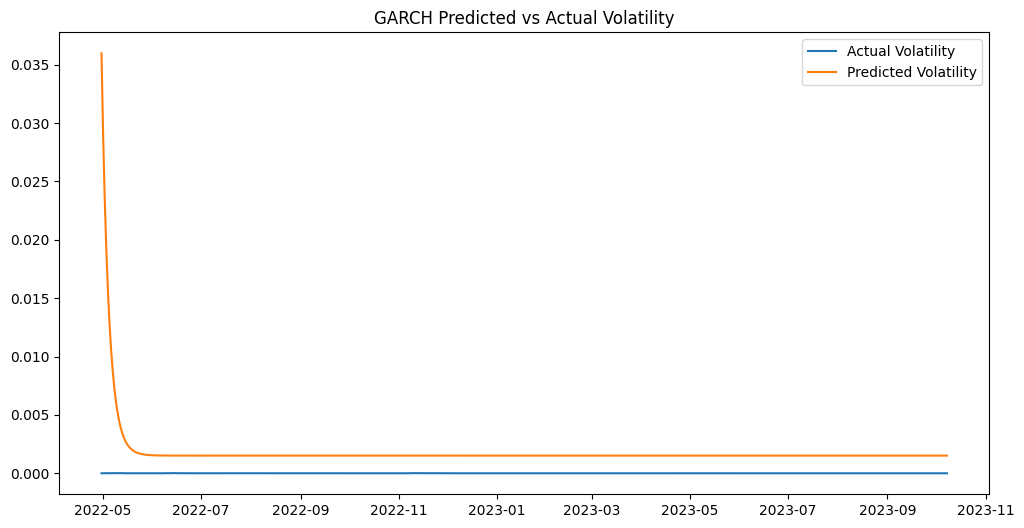

In [33]:
# Plot predicted and actual volatility
plt.figure(figsize=(12, 6))
plt.plot(RV_test, label="Actual Volatility")
plt.plot(predicted_volatility, label="Predicted Volatility")
plt.title("GARCH Predicted vs Actual Volatility")
plt.legend()
plt.show()


### Train-Test Split (with validation)

In [ ]:
# Train-Test Split (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(df))
r_train, r_test = df['log_return'][:train_size], df['log_return'][train_size:]
RV_train, RV_test = df['RV_d,t'][:train_size], df['RV_d,t'][train_size:]

# Reserve one part of training data for validation
valid_size = int(len(r_train) * 0.2)  # 20% of training data
r_val, RV_val = r_train[-valid_size:], RV_train[-valid_size:]
r_train, RV_train = r_train[:-valid_size], RV_train[:-valid_size]

# Remove NaN values
r_train = r_train.dropna()
RV_train = RV_train.dropna()
train_size = len(r_train)

print("Training Set:", r_train.shape, RV_train.shape)
print("Validation Set:", r_val.shape, RV_val.shape)
print("Test Set:", r_test.shape, RV_test.shape)

Training Set: (1690,) (1690,)
Validation Set: (422,) (422,)
Test Set: (528,) (528,)


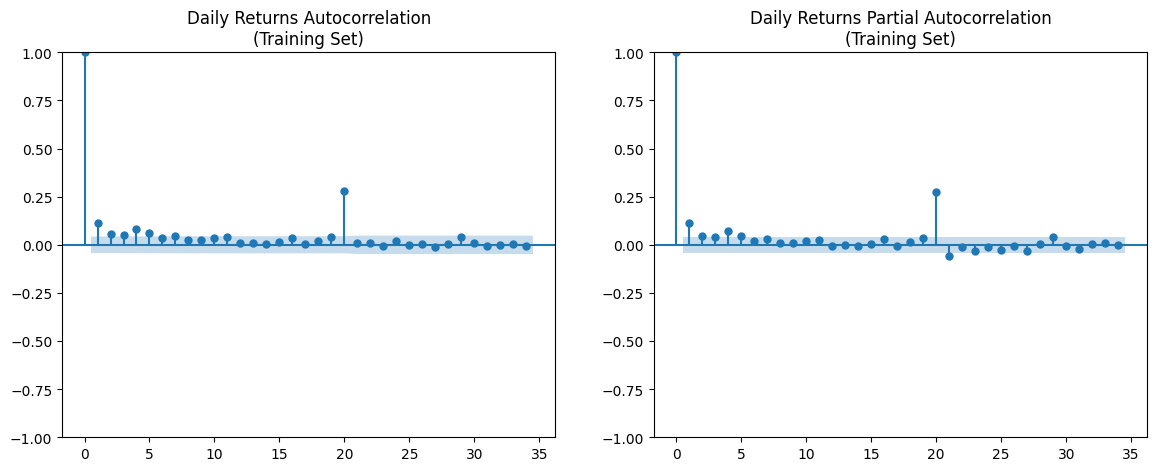

In [21]:
# Visualize the ACF and PACF of the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(r_train**2, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(r_train**2, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

#### Optimise p and q

In [99]:
# Store results
results = []

# Define range of p and q values to test
p_range = range(1,5)
q_range = range(1,5)

# Loop over all (p, q) combinations
for p in p_range:
    for q in q_range:
        predicted_volatility = []

        # Get the last conditional variance from training
        last_daily_returns = r_train[train_size-p-1:train_size-1]
        last_variances = df['RV_d,t'].iloc[train_size-q:train_size]
        
        try:
            model = arch_model(r_train, vol='Garch', p=p, q=q, rescale=False)
            garch_fit = model.fit(disp="off")
            params = garch_fit.params
            omega = params['omega']
            alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
            beta = [params[f'beta[{i+1}]'] for i in range(q)]

            # Compute volatility iteratively using GARCH equation
            for j in range(len(r_val)):
                r = r_val.iloc[j]
                RV = RV_val.iloc[j]               
                new_variance = omega
                for i in range(p):
                    new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
                for i in range(q):
                    new_variance += beta[i] * last_variances.iloc[-(1+i)]
                predicted_volatility.append(new_variance)
                # Update for next step
                last_variances = last_variances.shift(-1)
                last_variances.iloc[-1] = RV
                last_daily_returns = last_daily_returns.shift(-1)
                last_daily_returns.iloc[-1] = r 

            # Compute MSE
            mse = mean_squared_error(RV_val, predicted_volatility)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(RV_val, predicted_volatility)
            r2 = r2_score(RV_val, predicted_volatility)
            results.append((p, q, omega, alpha, beta, mse, rmse, mape, r2))

        except Exception as e:
            print(f"Skipping GARCH({p},{q}) due to error: {e}")

In [100]:
# Convert results to a DataFrame
gm_results = pd.DataFrame(results, columns=['p', 'q', 'omega', 'alpha', 'beta', 'MSE', 'RMSE', 'MAPE', 'R2'])

In [101]:
gm_results

,p,q,omega,alpha,beta,MSE,RMSE,MAPE,R2
0,1,1,0.000069,[0.09999971099383065],[0.8800003809514949],0.000025,0.005002,0.470880,-0.018300
1,1,2,0.000159,[0.1341471309603056],"[0.6020744541294727, 0.2265391930681001]",0.000021,0.004589,0.473071,0.142845
2,1,3,0.000252,[0.2101711343861097],"[0.20378488905162198, 2.850621903981418e-14, 0...",0.000022,0.004691,0.557727,0.104205
3,1,4,0.000252,[0.2101708897677154],"[0.20375894162631128, 3.476165292734964e-13, 0...",0.000022,0.004691,0.557730,0.104202
4,2,1,0.000069,"[0.04999980188466383, 0.04999978135178938]",[0.8800005769292412],0.000024,0.004880,0.466214,0.030875
5,2,2,0.000239,"[0.06152133491065123, 0.13660587654602166]","[9.223160023855035e-11, 0.7436928748842236]",0.000025,0.005048,0.593589,-0.037226
6,2,3,0.000299,"[0.18560710723914475, 0.057702116654317515]","[0.0676905068101004, 0.0, 0.6172248033133901]",0.000023,0.004749,0.590880,0.082162
7,2,4,0.000301,"[0.17570578094842956, 0.0737195418550516]","[0.12900911640210175, 0.12900904151479856, 0.3...",0.000019,0.004330,0.561117,0.236731
8,3,1,0.000069,"[0.03333675102060749, 0.03333322789865919, 0.0...",[0.8799968884667416],0.000024,0.004853,0.462580,0.041369
9,3,2,0.000159,"[0.13414740186469423, 7.312413762463655e-12, 7...","[0.6020492185239082, 0.22656397400914582]",0.000021,0.004589,0.473071,0.142856


In [102]:
# Find the best (p, q) with the lowest RMSE
best_params = gm_results.loc[gm_results['RMSE'].idxmin()]
best_p = best_params['p']
best_q = best_params['q']
best_rmse = best_params['RMSE']
print(f"Best GARCH({best_p},{best_q}) model with RMSE={best_rmse:.6f}")

# Find the best (p, q) with the largest R2
best_params = gm_results.loc[gm_results['R2'].idxmax()]
best_p = best_params['p']
best_q = best_params['q']
best_r2 = best_params['R2']
print(f"Best GARCH({best_p},{best_q}) model with R2={best_r2:.6f}")

Best GARCH(2,4) model with RMSE=0.004330
Best GARCH(2,4) model with R2=0.236731


In [103]:
# Best fit parameters from the best model
p = int(best_p)
q = int(best_q)
alpha = best_params['alpha']
beta = best_params['beta']
omega = best_params['omega']

### In-sample Predictions

In [104]:
# In-sample prediction
r_training = pd.concat([r_train, r_val])
RV_training = pd.concat([RV_train, RV_val])
skip = max(p, q)

in_samp_pred = []

for j in range(skip, len(r_training)):
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (r_training.iloc[j-i] ** 2)
    for i in range(q):
        new_variance += beta[i] * RV_training.iloc[j-i]
    in_samp_pred.append(new_variance) 

# Compute RMSE
in_samp_rmse = np.sqrt(mean_squared_error(RV_training[skip:], in_samp_pred))
print(f"In-sample RMSE={in_samp_rmse:.6f}")

In-sample RMSE=0.004790


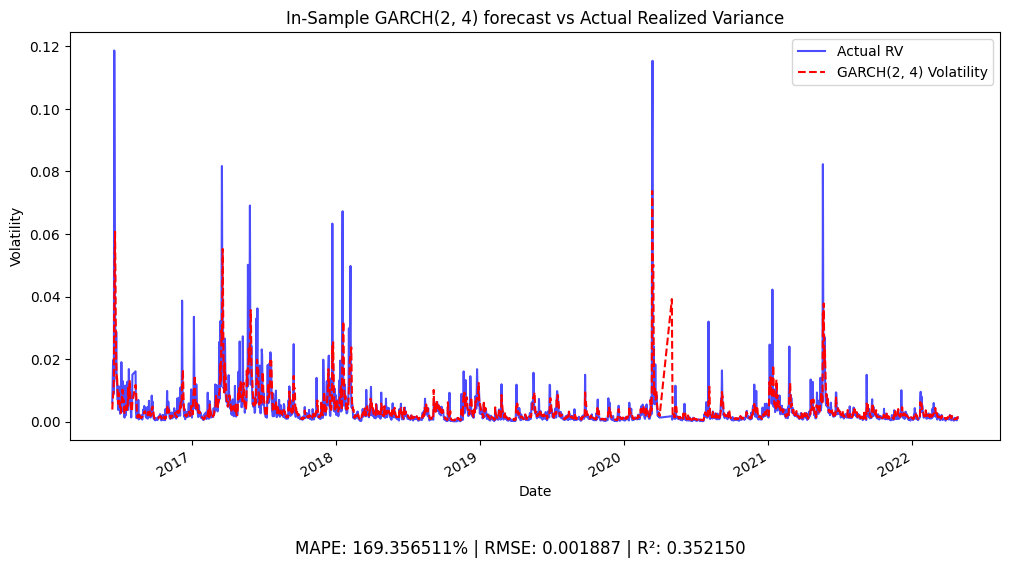

In [119]:
df_in_samp_pred = pd.DataFrame({'Predicted Volatility': in_samp_pred}, index=RV_training[skip:].index)
#save the predicted volatility to a csv file
df_in_samp_pred.to_csv('../../results/models/GARCH_in_sample.csv')

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
RV_training[skip:].plot(label='Actual RV', color="blue", alpha=0.7)
df_in_samp_pred['Predicted Volatility'].plot(label=f'GARCH({p}, {q}) Volatility', color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"In-Sample GARCH({p}, {q}) forecast vs Actual Realized Variance")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/In-Sample GARCH({p}, {q})_plot.png')
plt.show()

### Best GARCH Model on Testing Set

In [109]:
# Fit Best GARCH model to the training set
gm_best = arch_model(r_train, p=p, q=q, rescale=False)
gm_best_fit = gm_best.fit(disp='off')

In [110]:
# Extract parameters
params = gm_best_fit.params
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]
print(f"Estimated Parameters: \nomega={omega:.6f}, \nalpha={alpha}, \nbeta={beta}")

Estimated Parameters: 
omega=0.000301, 
alpha=[np.float64(0.17570578094842956), np.float64(0.0737195418550516)], 
beta=[np.float64(0.12900911640210175), np.float64(0.12900904151479856), np.float64(0.3088918305861826), np.float64(0.12900910639589044)]


In [111]:
# Get the last conditional variance from training
last_daily_returns = r_val[len(r_val)-p:len(r_val)]
last_variances = RV_val.iloc[len(RV_val)-q:len(RV_val)]

In [113]:
# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute forcase volatility on the test set
for j in range(len(r_test)):
    r = r_test.iloc[j]
    RV = RV_test.iloc[j]
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
    for i in range(q):
        new_variance += beta[i] * last_variances.iloc[-(1+i)]
    predicted_volatility.append(new_variance)
    # Update for next step
    last_variances = last_variances.shift(-1)
    last_variances.iloc[-1] = RV
    last_daily_returns = last_daily_returns.shift(-1)
    last_daily_returns.iloc[-1] = r 

In [114]:
# Calculate Error Metrics
mse = mean_squared_error(RV_test, predicted_volatility)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(RV_test, predicted_volatility)
r2 = r2_score(RV_test, predicted_volatility)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.000004
Root Mean Squared Error (RMSE): 0.001887
Mean Absolute Percentage Error (MAPE): 169.356511%
R² Score: 0.352150


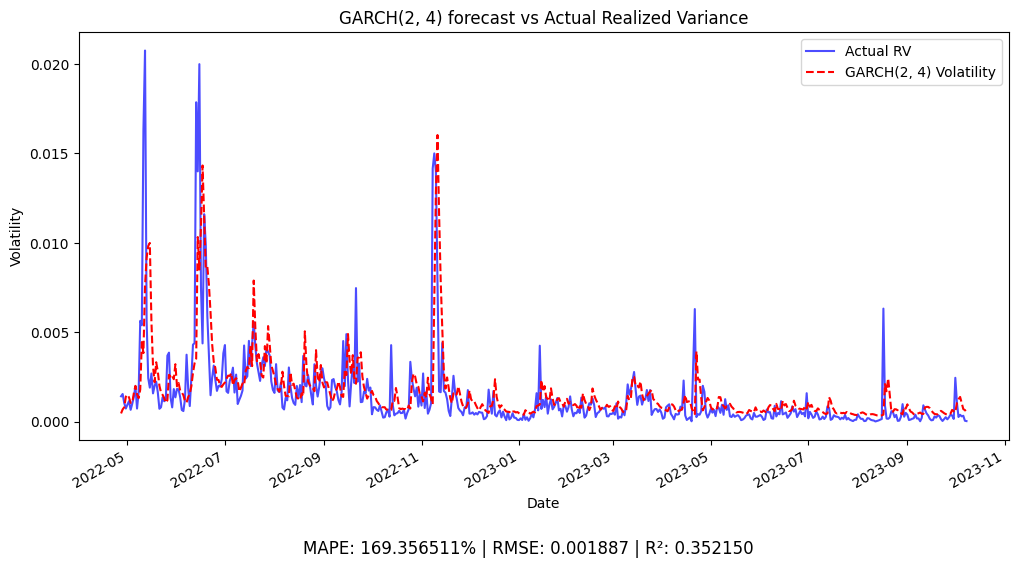

In [115]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, index=r_test.index)

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
RV_test.plot(label='Actual RV', color="blue", alpha=0.7)
df_pred['Predicted Volatility'].plot(label=f'GARCH({p}, {q}) Volatility', color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"GARCH({p}, {q}) forecast vs Actual Realized Variance")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/GARCH({p}, {q})_plot.png')
plt.show()

# Save the results to a CSV file
df_pred.to_csv('../../results/models/GARCH_predictions.csv')